In [15]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# import math
import matplotlib.pyplot as plt

In [16]:
df_atvi = pd.read_csv("atvi_weekly_return_volatility.csv")
df_spy = pd.read_csv("spy_weekly_return_volatility.csv")

In [17]:
def train_on_yr1(df, degrees_of_freedom):
    X_train = df[df["Year"] == 2021]
    X_train_green = X_train[X_train["Label"] == "green"]
    X_train_red = X_train[X_train["Label"] == "red"]
    p_green = X_train_green.shape[0]/52
    p_red = X_train_red.shape[0]/52
    
    X_train_mr_green = X_train_green[["mean_return"]].values.flatten()
    X_train_vol_green = X_train_green[["volatility"]].values.flatten()
    X_train_mr_red = X_train_red[["mean_return"]].values.flatten()
    X_train_vol_red = X_train_red[["volatility"]].values.flatten()
    
    mean_mr_green = np.mean(X_train_mr_green)
    std_mr_green = np.std(X_train_mr_green)
    mean_vol_green = np.mean(X_train_vol_green)
    std_vol_green = np.std(X_train_vol_green)
    mean_mr_red = np.mean(X_train_mr_red)
    std_mr_red = np.std(X_train_mr_red)
    mean_vol_red = np.mean(X_train_vol_red)
    std_vol_red = np.std(X_train_vol_red)
    
    X_test = df[df["Year"] == 2022]
    X_test_mr = X_test[["mean_return"]].values.flatten()
    X_test_vol = X_test[["volatility"]].values.flatten()
    
    # For T-stat
    # z_scores_mr_green = (X_test_mr - mean_mr_green)/(std_mr_green/math.sqrt(X_train_mr_green.shape[0]))
    # z_scores_vol_green = (X_test_vol - mean_vol_green)/(std_vol_green/math.sqrt(X_train_vol_green.shape[0]))
    # z_scores_mr_red = (X_test_mr - mean_mr_red)/(std_mr_red/math.sqrt(X_train_mr_red.shape[0]))
    # z_scores_vol_red = (X_test_vol - mean_vol_red)/(std_vol_red/math.sqrt(X_train_vol_red.shape[0]))
    
    z_scores_mr_green = (X_test_mr - mean_mr_green)/(std_mr_green)
    z_scores_vol_green = (X_test_vol - mean_vol_green)/(std_vol_green)
    z_scores_mr_red = (X_test_mr - mean_mr_red)/(std_mr_red)
    z_scores_vol_red = (X_test_vol - mean_vol_red)/(std_vol_red)
    
    prob_mr_green = stats.t.pdf(z_scores_mr_green, degrees_of_freedom)
    prob_vol_green = stats.t.pdf(z_scores_vol_green, degrees_of_freedom)
    p_test_green = prob_mr_green*prob_vol_green*p_green
    prob_mr_red = stats.t.pdf(z_scores_mr_red, degrees_of_freedom)
    prob_vol_red = stats.t.pdf(z_scores_vol_red, degrees_of_freedom)
    p_test_red = prob_mr_red*prob_vol_red*p_red
    
    normalized_probs_green = p_test_green/(p_test_green + p_test_red)
    normalized_probs_red = p_test_red/(p_test_green + p_test_red)
    y_pred = np.where(normalized_probs_green > normalized_probs_red, "green", "red")
    return y_pred

In [18]:
def get_metrics_pred(df):
    test = df[df["Year"] == 2022]
    y_test = test["Label"].values
    pred_df_half = train_on_yr1(df, 0.5)
    pred_df_1 = train_on_yr1(df, 1)
    pred_df_5 = train_on_yr1(df, 5)
    
    degrees_of_freedom = np.array([0.5, 1, 5])
    acc_half = accuracy_score(y_test, pred_df_half)
    conf_matrix_half = confusion_matrix(y_test, pred_df_half)
    tn = conf_matrix_half[0][0]
    fp = conf_matrix_half[0][1]
    fn = conf_matrix_half[1][0]
    tp = conf_matrix_half[1][1]
    tpr = round((tp/(tp + fn))*100, 2)
    tnr = round((tn/(tn + fp))*100, 2)
    print(f"Accuracy for DF(0.5) -> {round(acc_half*100, 2)} %")
    print(f"Recall for DF(0.5) -> {tpr} %")
    print(f"Specitivity for DF(0.5) -> {tnr} %\n")
    ConfusionMatrixDisplay(conf_matrix_half, display_labels=["red", "green"]).plot()
    plt.show()
    
    acc_1 = accuracy_score(y_test, pred_df_1)
    conf_matrix_1 = confusion_matrix(y_test, pred_df_1)
    tn = conf_matrix_1[0][0]
    fp = conf_matrix_1[0][1]
    fn = conf_matrix_1[1][0]
    tp = conf_matrix_1[1][1]
    tpr = round((tp/(tp + fn))*100, 2)
    tnr = round((tn/(tn + fp))*100, 2)
    print(f"Accuracy for DF(1) -> {round(acc_1*100, 2)} %")
    print(f"Recall for DF(1) -> {tpr} %")
    print(f"Specitivity for DF(1) -> {tnr} %\n")
    ConfusionMatrixDisplay(conf_matrix_1, display_labels=["red", "green"]).plot()
    plt.show()
    
    acc_5 = accuracy_score(y_test, pred_df_5)
    conf_matrix_5 = confusion_matrix(y_test, pred_df_5)
    tn = conf_matrix_5[0][0]
    fp = conf_matrix_5[0][1]
    fn = conf_matrix_5[1][0]
    tp = conf_matrix_5[1][1]
    tpr = round((tp/(tp + fn))*100, 2)
    tnr = round((tn/(tn + fp))*100, 2)
    print(f"Accuracy for DF(5) -> {round(acc_5*100, 2)} %")
    print(f"Recall for DF(5) -> {tpr} %")
    print(f"Specitivity for DF(5) -> {tnr} %\n")
    ConfusionMatrixDisplay(conf_matrix_5, display_labels=["red", "green"]).plot()
    plt.show()
    
    accs = np.array([acc_half, acc_1, acc_5])
    best_df = degrees_of_freedom[accs.argmax()]
    print(f"Best DF -> {best_df}")
    return best_df

In [19]:
def metrics_plot_bnh_df(df, stocks):
    best_df = get_metrics_pred(df)
    y_pred = train_on_yr1(df, best_df)
    X_test = df[df["Year"] == 2022]
    df_yr2_ret = X_test[["mean_return"]].values.flatten()
    i1, i2 = 100, 100
    bnh = []
    trade_nb_df = []
    for i in range(y_pred.shape[0]):
        i1 = i1*(1 + df_yr2_ret[i]/100)
        if y_pred[i] == "green":
            i2 = i2*(1 + df_yr2_ret[i]/100)
        bnh.append(i1)
        trade_nb_df.append(i2)
    
    plt.figure(figsize=(15, 10))
    plt.plot(bnh)
    plt.xlabel("Weeks")
    plt.ylabel("Returns")
    plt.title(f"For {stocks} - Buy and Hold")
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.plot(trade_nb_df)
    plt.xlabel("Weeks")
    plt.ylabel("Returns")
    plt.title(f"For {stocks} - According to Naive Bayes (Best DF - {best_df}) predicted labels")
    plt.show()
    
    print(f"Final Amount for BnH -> $ {round(i1, 2)}")
    print(f"Final Amount for Naive Bayes (Best DF = {best_df}) -> $ {round(i2, 2)}")

Accuracy for DF(0.5) -> 55.77 %
Recall for DF(0.5) -> 54.84 %
Specitivity for DF(0.5) -> 57.14 %



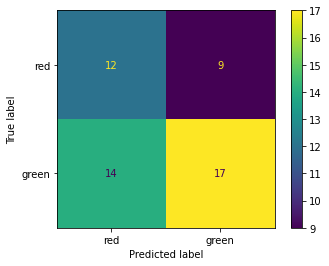

Accuracy for DF(1) -> 55.77 %
Recall for DF(1) -> 54.84 %
Specitivity for DF(1) -> 57.14 %



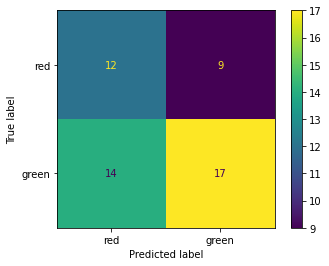

Accuracy for DF(5) -> 53.85 %
Recall for DF(5) -> 58.06 %
Specitivity for DF(5) -> 47.62 %



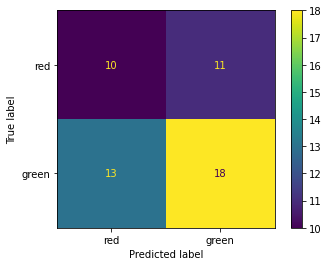

Best DF -> 0.5


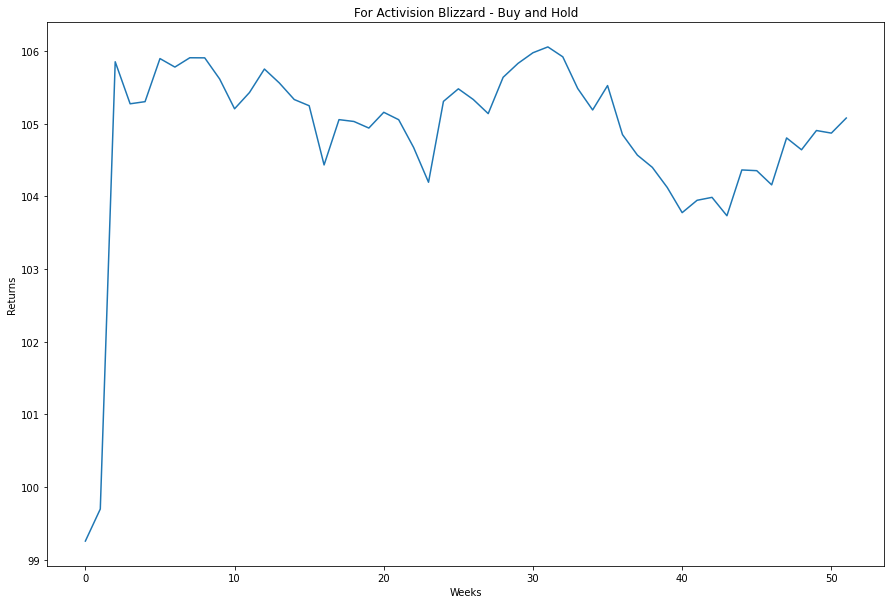

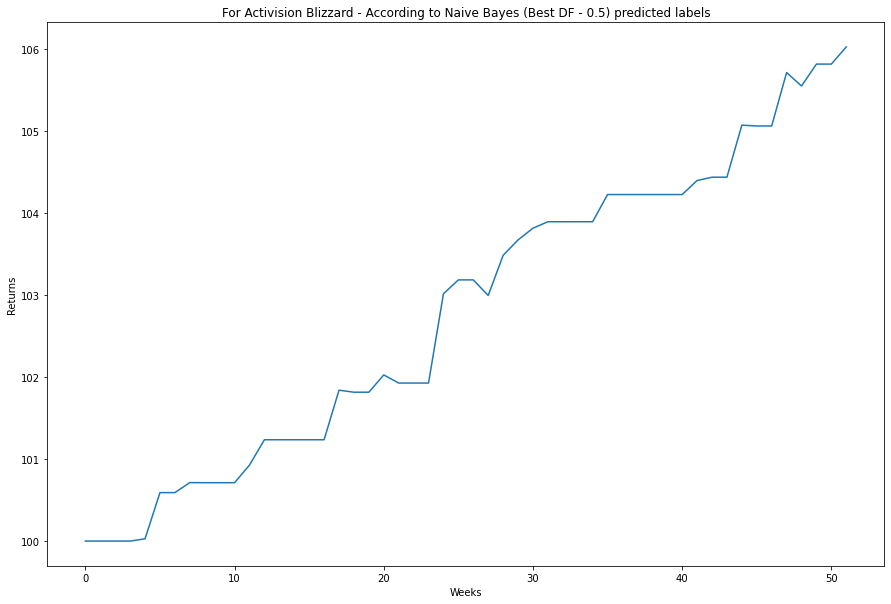

Final Amount for BnH -> $ 105.08
Final Amount for Naive Bayes (Best DF = 0.5) -> $ 106.03


In [20]:
metrics_plot_bnh_df(df_atvi, "Activision Blizzard")

Accuracy for DF(0.5) -> 34.62 %
Recall for DF(0.5) -> 0.0 %
Specitivity for DF(0.5) -> 100.0 %



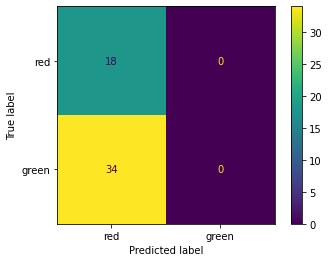

Accuracy for DF(1) -> 34.62 %
Recall for DF(1) -> 0.0 %
Specitivity for DF(1) -> 100.0 %



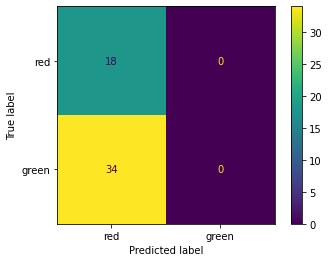

Accuracy for DF(5) -> 34.62 %
Recall for DF(5) -> 0.0 %
Specitivity for DF(5) -> 100.0 %



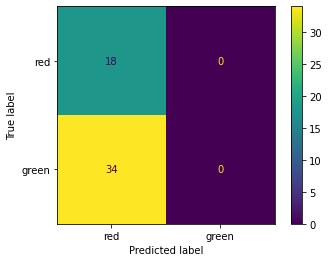

Best DF -> 0.5


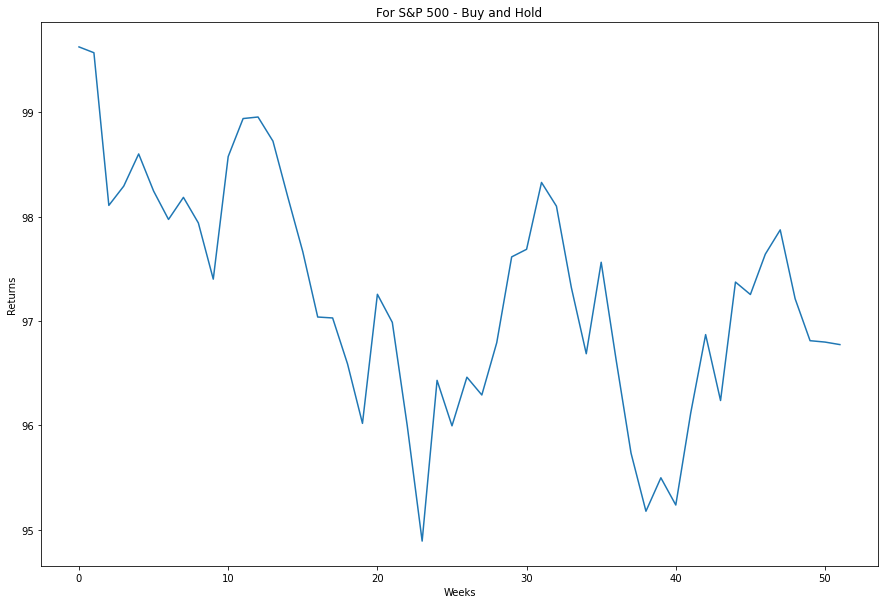

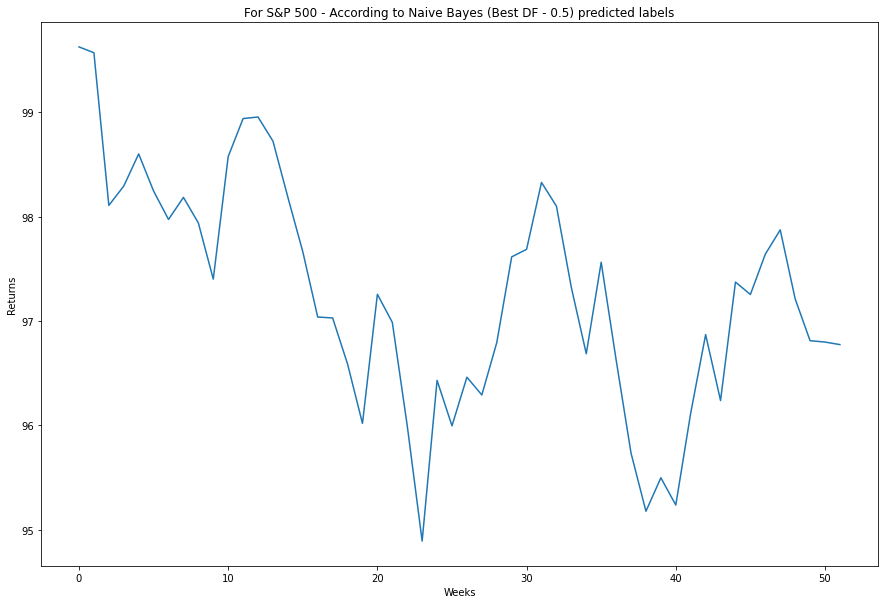

Final Amount for BnH -> $ 96.77
Final Amount for Naive Bayes (Best DF = 0.5) -> $ 96.77


In [21]:
metrics_plot_bnh_df(df_spy, "S&P 500")